## Пункт 1


Функция:

$$F(w) = -\frac{1}{N}\sum\limits_{i = 1}^N y_i\log{}\frac{e^{w^Tx_i}}{1 + e^{w^Tx_i}} + (1 - y_i)\log{}\frac{1}{1 + e^{w^Tx_i}} = -\frac{1}{N}\sum\limits_{i = 1}^N y_iw^Tx_i - \log{}\left(1 + e^{w^Tx_i}\right)$$

На матричном языке это можно записать как:

$$F(w) = -\frac{1}{N}\langle x^Tw, y\rangle + \frac{1}{N}\langle\log{}\left(1 + e^{x^Tw}\right), id\rangle = -\frac{1}{N}\langle x^Tw, y\rangle - \frac{1}{N}\langle\log{}\left(1 - \sigma(w^Tx)\right), id\rangle,$$ где $$\forall i \in \{1,\ldots, N\}\; id_i = 1$$

Грандиент:

$$\text{d}F(w) = -\frac{1}{N}\sum\limits_{i = 1}^Ny_i\text{d}w^Tx_i - \frac{e^{w^Tx_i}\text{d}w^Tx_i}{1 + e^{w^Tx_i}} = -\langle \frac{1}{N}\sum\limits_{i = 1}^N y_ix_i - \frac{e^{w^Tx_i}x_i}{1 + e^{w^Tx_i}}, \text{d}w\rangle \Rightarrow \nabla_w F = \frac{1}{N}\sum\limits_{i = 1}^N \left(\frac{e^{w^Tx_i}}{1 + e^{w^Tx_i}} - y_i\right)x_i$$

В матричном виде:

$$\nabla_w F = \frac{1}{N}x\left(\frac{e^{x^Tw}}{1 + e^{x^Tw}} - y\right) = \frac{1}{N}x\left(\sigma\left(x^Tw\right) - y\right)$$


Гессиан:

$$\text{d}(\text{d}_hF(w)) = -\text{d}\left(\frac{1}{N}\sum\limits_{i=1}^N y_ih^Tx_i - \frac{e^{w^Tx_i}h^Tx_i}{1 + e^{w^Tx_i}}\right) = \frac{1}{N}\sum\limits_{i = 1}^N\frac{\text{d}w^Tx_ix_i^The^{w^Tx_i}}{(1 + e^{w^Tx_i})^2} = \langle \frac{1}{N}\sum\limits_{i = 1}^N\frac{x_ix_i^Te^{w^Tx_i}}{(1 + e^{w^Tx_i})^2}h, \text{d}w \rangle \Rightarrow \nabla_w^2 F = \frac{1}{N}\sum\limits_{i = 1}^N\frac{x_ix_i^Te^{w^Tx_i}}{(1 + e^{w^Tx_i})^2}$$

В матричной формулровке:

$$\nabla^2_w F = \frac{1}{N}xMx^T,$$
где
$$M_{ij} = \left\{\begin{array}{l}
    0, i\neq j \\
    \frac{e^{w^Tx_i}}{(1 + e^{w^Tx_i})^2} = \sigma(w^Tx_i)(1 - \sigma(w^Tx_i)), i = j
\end{array}\right.$$

## Пункт 2
(все тесты ниже происходят на датасете a1a.txt)

In [ ]:
import numpy as np
import scipy.sparse as sp
from sklearn.datasets import load_svmlight_file
from oracle import Oracle, make_oracle, der, der2
import scipy as sc

In [ ]:
orac = make_oracle('a1a.txt')

x, y = load_svmlight_file('a1a.txt', zero_based=False)
m = x[0].shape[1] + 1

Проверим на всякий случай, что численный гессиан работает правильно. На функции $f1(x) = x^Tx$, ожидаем полчить $\nabla^2 f = 2id_n$, где $id$ -- единичная марица

In [ ]:
n = np.random.randint(10, 100)
f = lambda x: (x.T @ x).item()
x = np.random.normal(size=(n, 1))
err = np.linalg.norm(der2(f, x) - 2 * np.eye(n))
print('Норма разности гессиана и единичной матрицы: ', err)

Норма разности гессиана и единичной матрицы:  9.588446187384862e-07


Проверим теперь с помощью разностного дифференцирования, что градиент и гессиан вычисленны корректно

In [ ]:
def test(oracle, m):
    w = np.random.normal(size=(m, 1))
    f = lambda w: oracle.value(w)
    grad_norm = np.linalg.norm(oracle.grad(w) - der(f, w))
    hess_norm = np.linalg.norm(oracle.hessian(w) - der2(f, w))
    print('Норма разности аналитического и численного градиентов: ', grad_norm)
    print('Норма разности аналитического и численного гессианов: ', hess_norm)

test(orac, m)

Норма разности аналитического и численного градиентов:  8.644339402609234e-09
Норма разности аналитического и численного гессианов:  3.777654398377981e-08


In [ ]:
test(orac, m)

Норма разности аналитического и численного градиентов:  4.718350033424151e-09
Норма разности аналитического и численного гессианов:  3.815734187017456e-08


In [ ]:
test(orac, m)

Норма разности аналитического и численного градиентов:  3.6418521318910875e-09
Норма разности аналитического и численного гессианов:  3.914370038255826e-08


Будем исследовать сходимость наших методов на нулевом векторе

In [ ]:
w0 = np.zeros(m).reshape((-1, 1))
true_val = sc.optimize.minimize(lambda w: orac.value(w), w0).fun

In [ ]:
true_val

0.29787637646449144

## Пункт 3

Наyчимся рисовать графики, которые требуются в этом и следующих пунктах

In [ ]:
from methods import *
import matplotlib.pyplot as plt

In [ ]:
def non_hfn_plotter(optimizer, line_search_methods, oracle, w0, true_val):
    opt_name = optimizer.name
    names = []
    rel_errs = []
    vals = []
    times = []
    oracle_calls = []
    n_its = []
    n = 0
    for method in line_search_methods:
        n += 1
        names.append(method.name)
        point = optimizer(oracle, w0, method)
        rel_errs.append(optimizer.rel_errs)
        vals.append(optimizer.values)
        times.append(optimizer.times)
        oracle_calls.append(optimizer.orac_calls)
        n_its.append(optimizer.n_iter)
    
    plt.title('Отношение норм градиентов vs время, ' + opt_name)
    for i in range(n):
        plt.plot(times[i], rel_errs[i], label=names[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('вермя работы, с')
    plt.ylabel('(grad(w_k) / grad(w0))^2')
    plt.show()
    
    plt.title('Отношение норм градиентов vs число вызовов оракула, ' + opt_name)
    for i in range(n):
        plt.plot(oracle_calls[i], rel_errs[i], label=names[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во вызовов оракула')
    plt.ylabel('(grad(w_k) / grad(w0))^2')
    plt.show()
    
    plt.title('Отношение норм градиентов vs число итераций, ' + opt_name)
    for i in range(n):
        plt.plot(list(range(1, n_its[i] + 1)), rel_errs[i], label=names[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во итераций')
    plt.ylabel('(grad(w_k) / grad(w0))^2')
    plt.show()
              
    plt.title('Модуль разности значений vs время, ' + opt_name)
    for i in range(n):
        plt.plot(times[i], abs(np.array(vals[i]) - true_val), label=names[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('вермя работы, с')
    plt.ylabel('|F(w_k) - F(w*)|')
    plt.show()
    
    plt.title('Модуль разности значений vs число вызовов оракула, ' + opt_name)
    for i in range(n):
        plt.plot(oracle_calls[i], abs(np.array(vals[i]) - true_val), label=names[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во вызовов оракула')
    plt.ylabel('|F(w_k) - F(w*)|')
    plt.show()
    
    plt.title('Модуль разности значений vs число итераций, ' + opt_name)
    for i in range(n):
        plt.plot(list(range(1, n_its[i] + 1)), abs(np.array(vals[i]) - true_val), label=names[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во итераций')
    plt.ylabel('|F(w_k) - F(w*)|')
    plt.show()

In [ ]:
line_searches_for_gd = [GoldenRatioLineSearch(), BrentLineSearch(), ArmijoLineSearch(), WolfeLineSearch(), 
                       NesterovLineSearch()]
line_searches_for_newton = [GoldenRatioLineSearch(), BrentLineSearch(), ArmijoLineSearch(), WolfeLineSearch()]

Исследеуем отдельно зависимость скорости сходимости градиентного спуска от выбора констант в условиях Армихо и Вульфа. Для Армихо будем менять константу $c$ в условии Армихо:
$$f(x + \alpha p_k) \leq f(x_k) + c\alpha p_k^T\nabla f(x_k)$$
А также константу $p$ в адаптивном поиске длины шага. Попробуем взять пары $c = 0.0001$ (слабое условие на значение функции в новой точке); $c=0.4$ (сильное условие на значении фукции в новой точке); $c=0.1$ (промежуточное значение $c$).

In [ ]:
armijo1 = ArmijoLineSearch(c=0.0001)
armijo2 = ArmijoLineSearch(c=0.4)
armijo3 = ArmijoLineSearch(c=0.1)

optimizer = OptimizeGD()
for _ in range(3):
    w = np.random.normal(size=(m, 1))
    point = optimizer(orac, w, armijo1)
    print('с=0.0001: количество итераций - {0}, ошибка - {1}, предсказанное значение - {2}'.format(optimizer.n_iter,
          optimizer.rel_errs[-1], optimizer.values[-1]))
    point = optimizer(orac, w, armijo2)
    print('с=0.4: количество итераций - {0}, ошибка - {1}, предсказанное значение - {2}'.format(optimizer.n_iter,
          optimizer.rel_errs[-1], optimizer.values[-1]))
    point = optimizer(orac, w, armijo3)
    print('с=0.1: количество итераций - {0}, ошибка - {1}, предсказанное значение - {2}'.format(optimizer.n_iter,
          optimizer.rel_errs[-1], optimizer.values[-1]))

с=0.0001: количество итераций - 10000, ошибка - 5.274924677102321e-07, предсказанное значение - 0.30064492968359247
с=0.4: количество итераций - 10000, ошибка - 5.274924677102321e-07, предсказанное значение - 0.30064492968359247
с=0.1: количество итераций - 10000, ошибка - 5.274924677102321e-07, предсказанное значение - 0.30064492968359247
с=0.0001: количество итераций - 10000, ошибка - 1.4629396509876434e-06, предсказанное значение - 0.3007614071757757
с=0.4: количество итераций - 10000, ошибка - 1.4629396509876434e-06, предсказанное значение - 0.3007614071757757
с=0.1: количество итераций - 10000, ошибка - 1.4629396509876434e-06, предсказанное значение - 0.3007614071757757
с=0.0001: количество итераций - 10000, ошибка - 2.963721448906259e-06, предсказанное значение - 0.3005608597597056
с=0.4: количество итераций - 10000, ошибка - 2.963721448906259e-06, предсказанное значение - 0.3005608597597056
с=0.1: количество итераций - 10000, ошибка - 2.963721448906259e-06, предсказанное значени

Делаем вывод, что скорость сходимости метода не зависит от выбора константы в условии Армихо. попробуем поварьировать константы $c_1, c_2$ в условиях Вульфа. Возьмём $c1 = 0.0001, c_2 = 0.9$; $c_1 = 0.4$, $c_2 = 0.6$; $c_1 = 0.25, c_2 = 0.75$

In [ ]:
wolfe1 = WolfeLineSearch(c1=0.0001, c2=0.9)
wolfe2 = WolfeLineSearch(c1=0.4, c2=0.6)
wolfe3 = WolfeLineSearch(c1=0.25, c2=0.75)

optimizer = OptimizeGD()
for _ in range(3):
    w = np.random.normal(size=(m, 1))
    point = optimizer(orac, w, wolfe1)
    print('с1=0.0001, c2=0.9: количество итераций - {0}, ошибка - {1}, предсказанное значение - {2}'.format(optimizer.n_iter,
          optimizer.rel_errs[-1], optimizer.values[-1]))
    point = optimizer(orac, w, wolfe2)
    print('с1=0.4, c2=0.6: количество итераций - {0}, ошибка - {1}, предсказанное значение - {2}'.format(optimizer.n_iter,
          optimizer.rel_errs[-1], optimizer.values[-1]))
    point = optimizer(orac, w, wolfe3)
    print('с1=0.25, c2=0.75: количество итераций - {0}, ошибка - {1}, предсказанное значение - {2}'.format(optimizer.n_iter,
          optimizer.rel_errs[-1], optimizer.values[-1]))
    print('*******************************************************************************************************')

с1=0.0001, c2=0.9: количество итераций - 10000, ошибка - 1.808393010762729e-08, предсказанное значение - 0.29838966495042135
с1=0.4, c2=0.6: количество итераций - 10000, ошибка - 7.217240951582485e-08, предсказанное значение - 0.2985292607804972
с1=0.25, c2=0.75: количество итераций - 10000, ошибка - 1.3771643397210388e-08, предсказанное значение - 0.2984489074093751
*******************************************************************************************************
с1=0.0001, c2=0.9: количество итераций - 10000, ошибка - 1.344343208059781e-07, предсказанное значение - 0.29839763773547856
с1=0.4, c2=0.6: количество итераций - 10000, ошибка - 1.935636255523121e-07, предсказанное значение - 0.2985409635511952
с1=0.25, c2=0.75: количество итераций - 10000, ошибка - 1.422002515330248e-07, предсказанное значение - 0.2984559104416089
*******************************************************************************************************
с1=0.0001, c2=0.9: количество итераций - 9777, ошибка

Также убеждаемся в том, что в пределах условий $0 < c_1 < 0.5$, $с_1 < c_2 < 1$ константы $c_1$ и $c_2$ не оказывают значительного влиния на скорость сходимости метода.

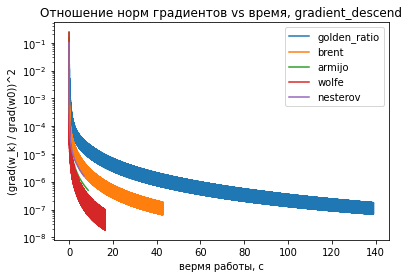

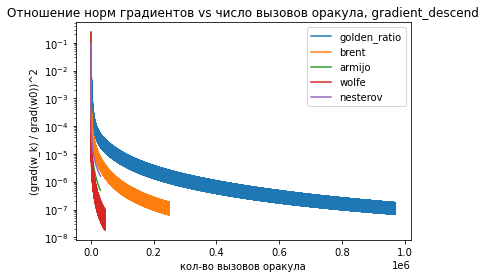

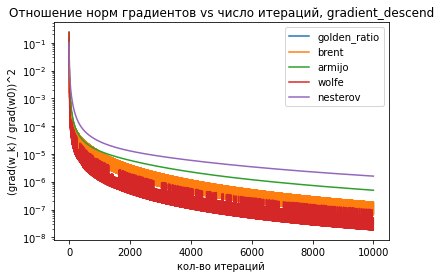

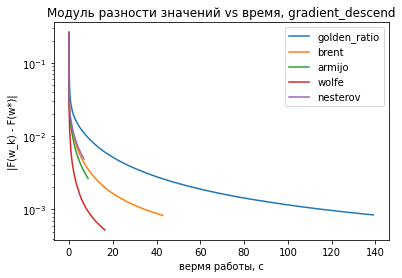

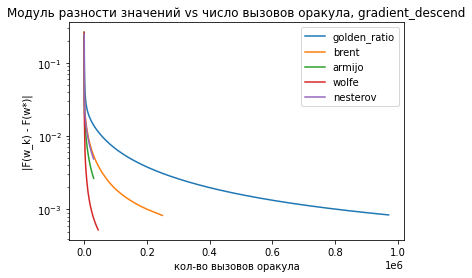

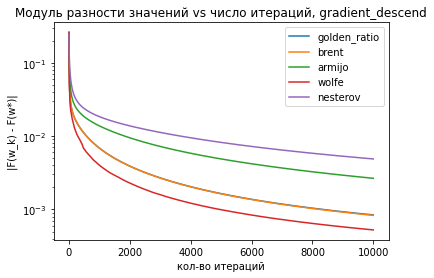

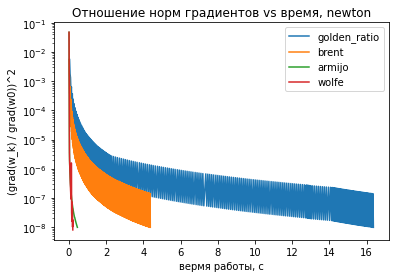

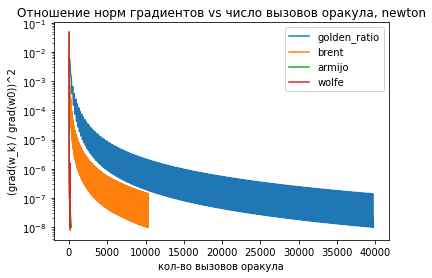

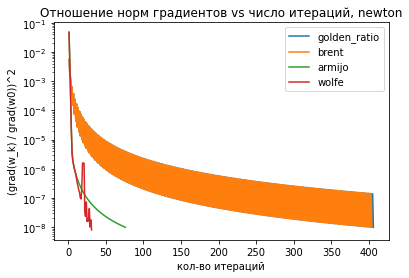

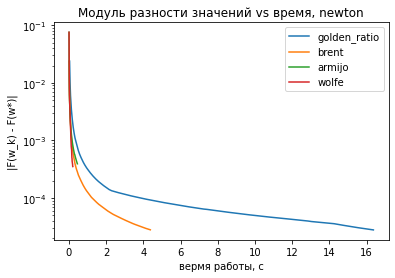

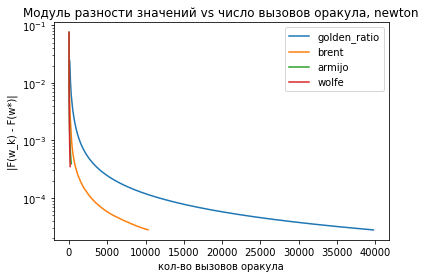

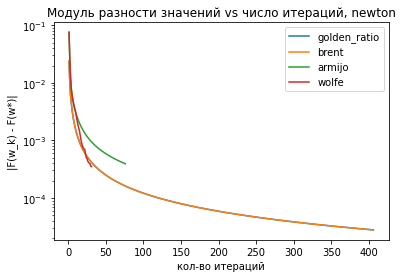

In [ ]:
non_hfn_plotter(OptimizeGD(), line_searches_for_gd, orac, w0, true_val)
non_hfn_plotter(OptimizeNewton(), line_searches_for_newton, orac, w0, true_val)

Изходя из графиков и для метода градиентного спуска и для метода Ньютона наиболее выйгрышной line-search стратегией являются неточная оптимизация с условиями Вульфа.

Исследуем теперь скорость сходимости HFN в зависимости от стратегии выбора точности, с которой решается система уравнений в CG. Мы будем сравнивать 3 стратегии $\eta_k = const = 0.0004$ и $\eta_k = \min(1/2, \sqrt{\|\nabla f(w_k)\|})$ и $\eta_k = \min(1/2, \|\nabla f(w_k)\|)$, с условием остановки CG $\|r_k\| \leq \eta_k\|\nabla f(w_k)\|$ (const, sqrt_adaptive и adaptive соответственно). Сравним сразу эти стратегии с методом Ньютона + Wolfe и градиентным спуском + Wolfe.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


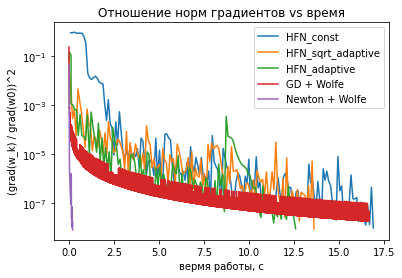

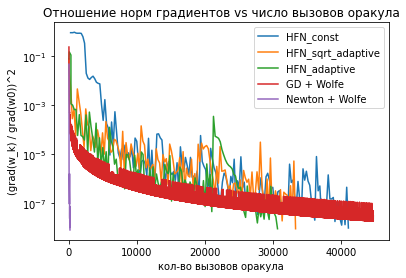

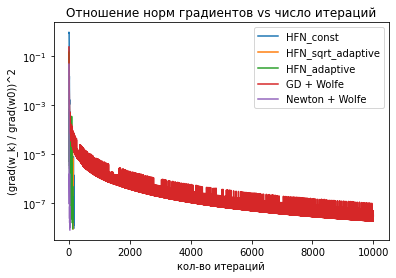

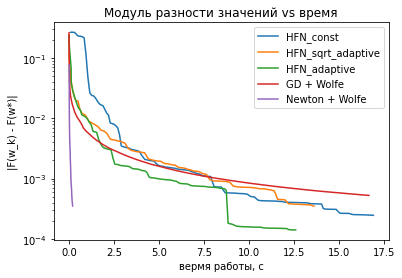

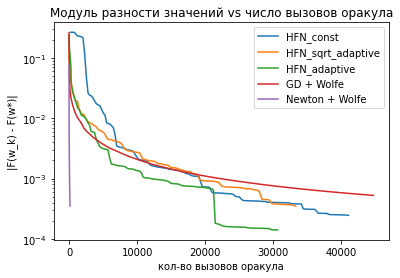

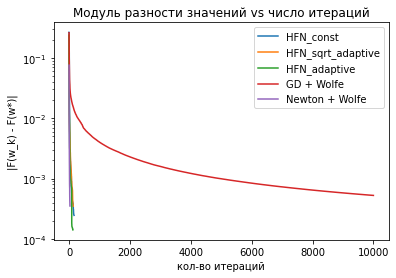

In [ ]:
def hfn_plotter(oracle, w0):
    optimizer = OptimizeHFN()

    rel_errs = []
    vals = []
    times = []
    oracle_calls = []
    n_its = []

    labels = ['HFN_const', 'HFN_sqrt_adaptive', 'HFN_adaptive', 'GD + Wolfe', 'Newton + Wolfe']

    n = len(labels)

    for strat in ['const', 'sqrt_adaptive', 'adaptive']:
        point = optimizer(oracle, w0, strat)
        rel_errs.append(optimizer.rel_errs)
        vals.append(optimizer.values)
        times.append(optimizer.times)
        oracle_calls.append(optimizer.orac_calls)
        n_its.append(optimizer.n_iter)

    optimizer = OptimizeGD()
    point = optimizer(oracle, w0, WolfeLineSearch())
    rel_errs.append(optimizer.rel_errs)
    vals.append(optimizer.values)
    times.append(optimizer.times)
    oracle_calls.append(optimizer.orac_calls)
    n_its.append(optimizer.n_iter)

    optimizer = OptimizeNewton()
    point = optimizer(oracle, w0, WolfeLineSearch())
    rel_errs.append(optimizer.rel_errs)
    vals.append(optimizer.values)
    times.append(optimizer.times)
    oracle_calls.append(optimizer.orac_calls)
    n_its.append(optimizer.n_iter)

    plt.title('Отношение норм градиентов vs время')
    for i in range(n):
        plt.plot(times[i], rel_errs[i], label=labels[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('вермя работы, с')
    plt.ylabel('(grad(w_k) / grad(w0))^2')
    plt.show()

    plt.title('Отношение норм градиентов vs число вызовов оракула')
    for i in range(n):
        plt.plot(oracle_calls[i], rel_errs[i], label=labels[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во вызовов оракула')
    plt.ylabel('(grad(w_k) / grad(w0))^2')
    plt.show()

    plt.title('Отношение норм градиентов vs число итераций')
    for i in range(n):
        plt.plot(list(range(1, n_its[i] + 1)), rel_errs[i], label=labels[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во итераций')
    plt.ylabel('(grad(w_k) / grad(w0))^2')
    plt.show()

    plt.title('Модуль разности значений vs время')
    for i in range(n):
        plt.plot(times[i], abs(np.array(vals[i]) - true_val), label=labels[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('вермя работы, с')
    plt.ylabel('|F(w_k) - F(w*)|')
    plt.show()

    plt.title('Модуль разности значений vs число вызовов оракула')
    for i in range(n):
        plt.plot(oracle_calls[i], abs(np.array(vals[i]) - true_val), label=labels[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во вызовов оракула')
    plt.ylabel('|F(w_k) - F(w*)|')
    plt.show()

    plt.title('Модуль разности значений vs число итераций')
    for i in range(n):
        plt.plot(list(range(1, n_its[i] + 1)), abs(np.array(vals[i]) - true_val), label=labels[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel('кол-во итераций')
    plt.ylabel('|F(w_k) - F(w*)|')
    plt.show()
    
hfn_plotter(orac, w0)

Если смотреть на более адекватные графики для $\log{}(|F(w_k) - F(w*)|)$, то можно сделать вывод, что самая лучшая стратегия -- это метод Ньютона с неточной линейным поиском по условиям Вульфа. Для HFN метода наиболе оптимальным критерием остановки CG является стратегия с $\eta_k = \min(1/2, \sqrt{\|\nabla f(w_k)\|})$ (то есть sqrt_adaptive в наших терминах)

Проделаем аналогичные эксперименты для breast cancer датасета, для случайной начальной точки $w0$, чтобы убедиться, что сделанные нами выводы не зависят от датасета 

In [ ]:
orac = make_oracle('breast-cancer_scale.txt')

x, y = load_svmlight_file('breast-cancer_scale.txt', zero_based=False)
m = x[0].shape[1] + 1
w0 = np.random.normal(size=(m, 1))
true_val = sc.optimize.minimize(lambda w: orac.value(w), w0).fun

Графики для градиентного спуска

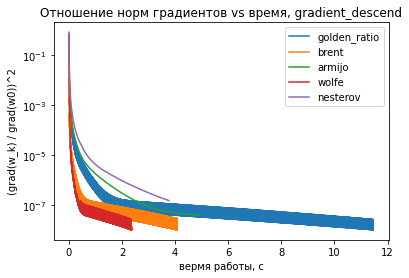

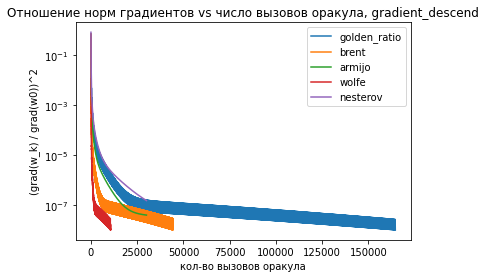

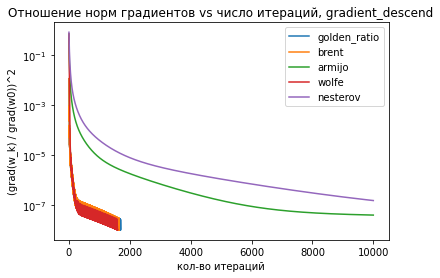

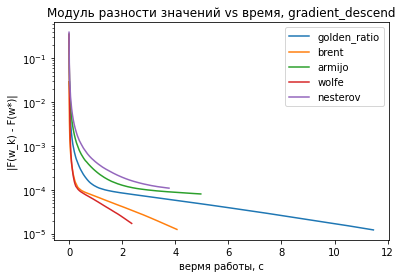

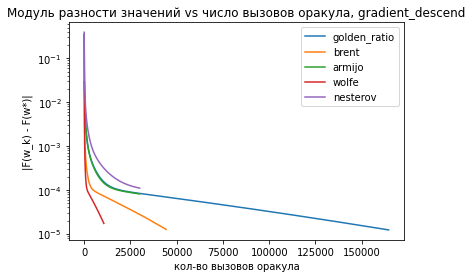

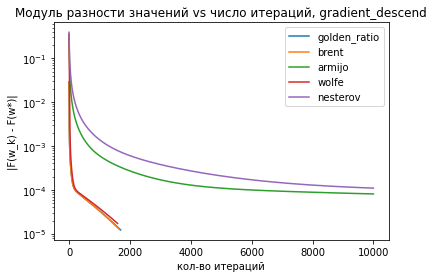

In [ ]:
non_hfn_plotter(OptimizeGD(), line_searches_for_gd, orac, w0, true_val)

Метод сходится, лучшие результаты показывает точная минимизация методом брента и неточная с условиями Вульфа.


Графики для метода Ньютона

/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()


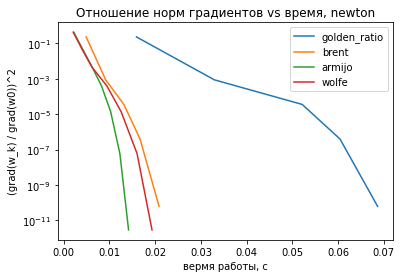

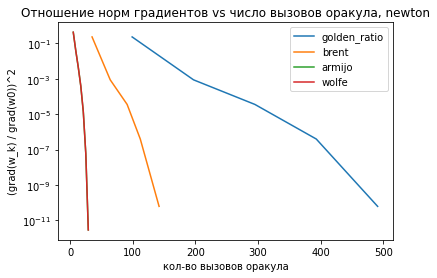

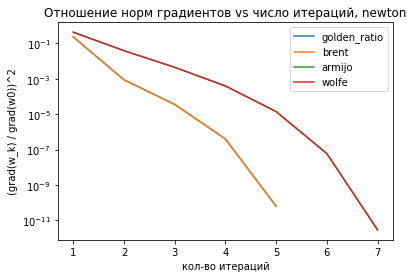

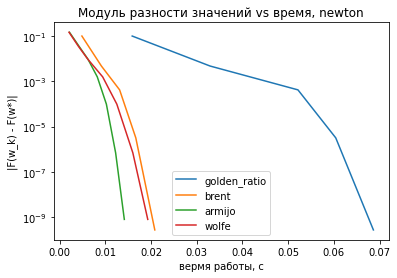

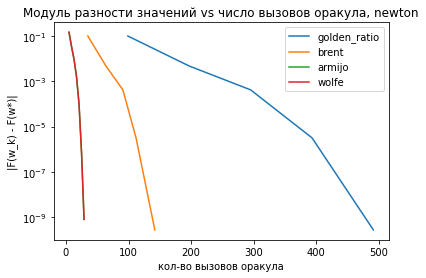

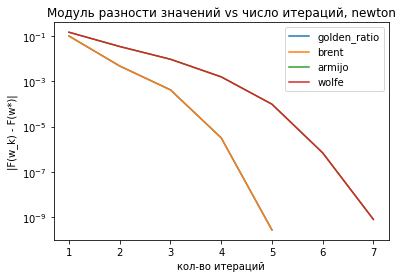

In [ ]:
non_hfn_plotter(OptimizeNewton(), line_searches_for_newton, orac, w0, true_val)

Графики для HFN

/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


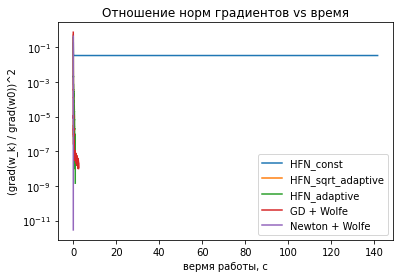

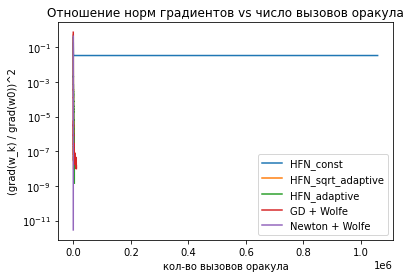

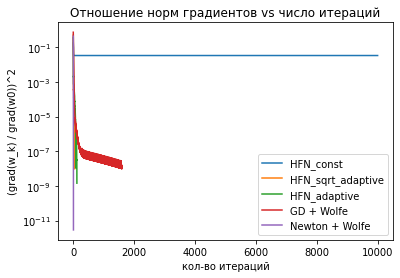

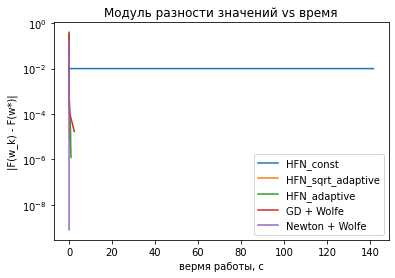

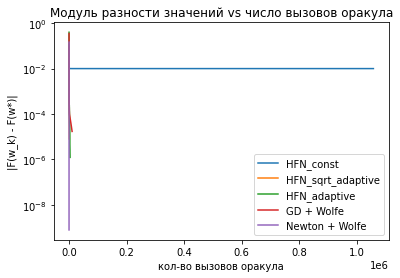

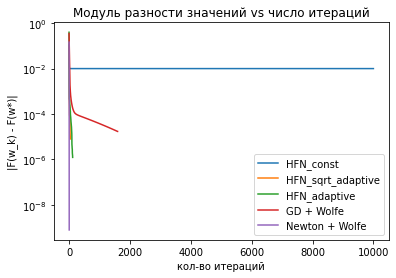

In [ ]:
hfn_plotter(orac, w0)

HFN с константной стратегией решения задачи CG  показывает свою несостоятельность, в остальном все результаты соответствуют выводам, сделаным на предыдущем датасете.



И чтоб наверняка сделаем все то же самое для случайно сгенерированного, как указано в задании, датасета

In [ ]:
orac = make_oracle('my_dataset.txt')

x, y = load_svmlight_file('my_dataset.txt', zero_based=False)
m = x[0].shape[1] + 1
w0 = np.random.normal(size=(m, 1))
true_val = sc.optimize.minimize(lambda w: orac.value(w), w0).fun

/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()
/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()
/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()
/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()


Градиентный спуск

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


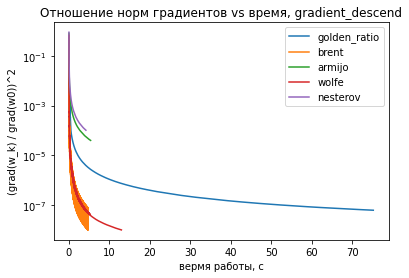

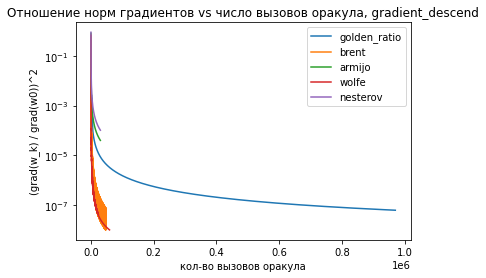

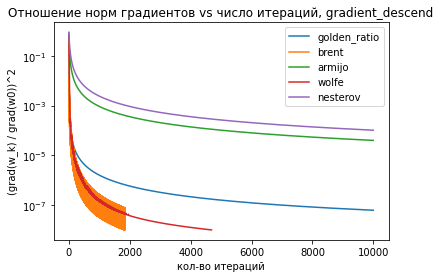

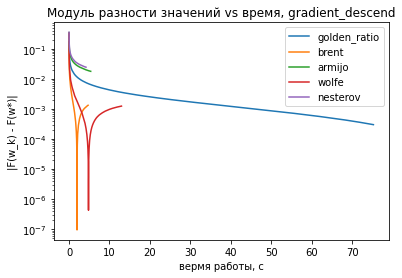

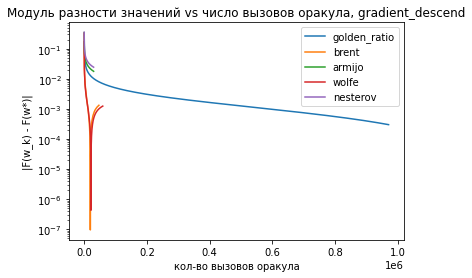

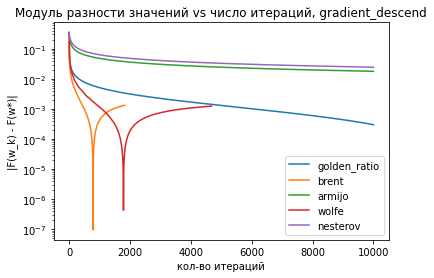

In [ ]:
non_hfn_plotter(OptimizeGD(), line_searches_for_gd, orac, w0, true_val)

Ньютон

/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


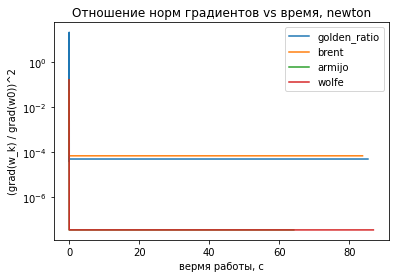

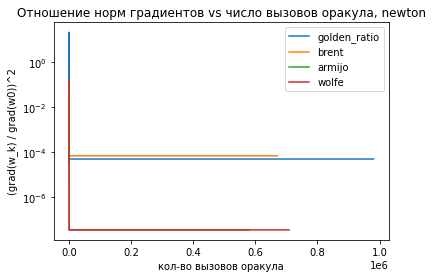

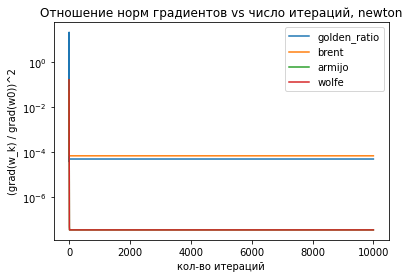

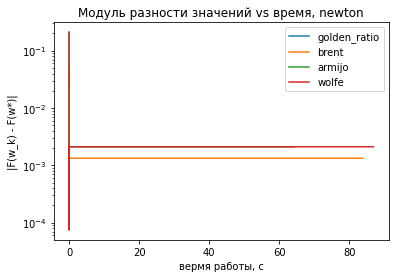

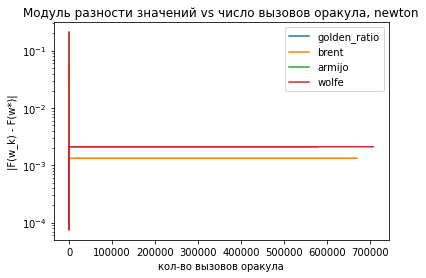

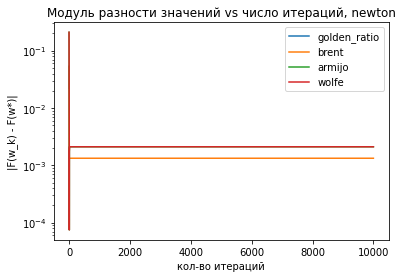

In [ ]:
non_hfn_plotter(OptimizeNewton(), line_searches_for_newton, orac, w0, true_val)

In [ ]:
HFN

/content/oracle.py:22: RuntimeWarning: overflow encountered in exp
  return ((- self.y.reshape((1, -1)) @ z + id @ np.log(1 + np.exp(z))) / self.n).item()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/content/oracle.py:35: RuntimeWarning: overflow encountered in square
  M = sp.diags((np.exp(z) / (1 + np.exp(z)) ** 2).reshape((1, -1))[0])
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


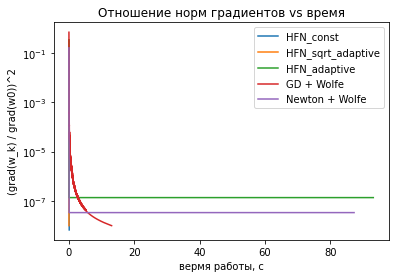

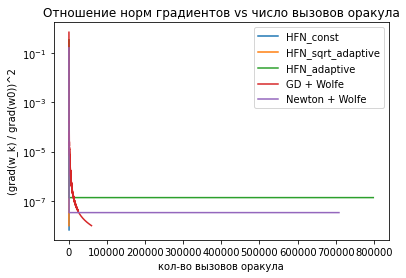

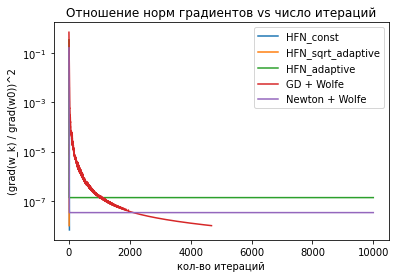

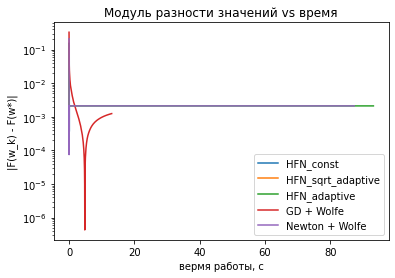

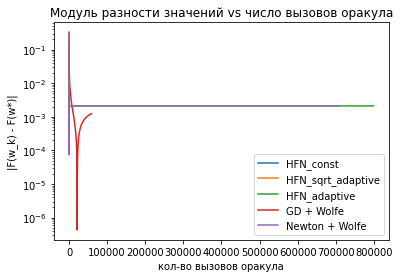

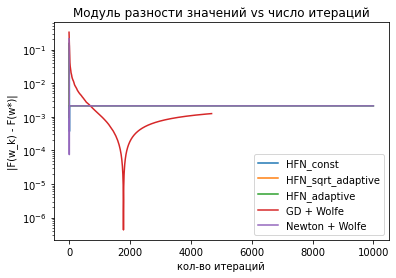

In [ ]:
hfn_plotter(orac, w0)